Third sandbox. Same dataset as the second one. This time, switched to `DecisionTreeClassifier`, which immediately improved the results.

In [1]:
import pandas as pd
import numpy as np
from time import time
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, f1_score
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
# https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
df = pd.read_csv('creditcard.csv')
print(df.columns)
print(df['Class'].value_counts())

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')
Class
0    284315
1       492
Name: count, dtype: int64


In [5]:
all_x = df[df.columns[:-1]]
all_y = df['Class']

In [7]:
def fit_with_size(X_sample, y_sample, seed, train_size, verbose=False):
    X_train, X_test, y_train, y_test = train_test_split(
        X_sample, y_sample,
        train_size=train_size,
        stratify=y_sample,
        random_state=seed  # make less random
    )

    if verbose:
        print("Fitting model with", train_size, "of the data...", end=' ')
        start_time = time()
    np.random.seed(seed)  # make less random
    model = DecisionTreeClassifier().fit(X_train, y_train)
    if verbose:
        end_time = time()
        print("done in", round(end_time-start_time), "seconds.")

    return model, X_test, y_test

In [9]:
def get_metrics(model, X_test, y_test):
    y_pred = model.predict(X_test)

    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return precision, recall, f1

In [11]:
# https://www.kdnuggets.com/2023/03/bootstrapping.html
def bootstrap(X_df, y_df, n_samples, train_size):
    results = []
    for i in tqdm(range(n_samples)):
        run = {}
        np.random.seed(i)  # make less random
        indices = np.random.choice(X_df.shape[0], size=X_df.shape[0], replace=True)
        X_sample = X_df.values[indices, :]
        y_sample = y_df.values[indices]

        model, X_test, y_test = fit_with_size(X_sample, y_sample, i, train_size)
        precision, recall, f1 = get_metrics(model, X_test, y_test)

        run["Seed"] = i
        run["Precision"] = precision
        run["Recall"] = recall
        run["F1"] = f1
        run["Indices"] = indices
        results.append(run)
    return pd.DataFrame(results)

In [25]:
pred_df = bootstrap(all_x, all_y, 10, 0.6)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:31<00:00,  9.11s/it]


In [26]:
pred_df.sort_values(by="F1", ascending=False).head()

,Seed,Precision,Recall,F1,Indices
3,3,0.864734,0.895000,0.879607,"[71530, 198296, 77049, 48056, 11261, 215699, 2..."
9,9,0.892655,0.854054,0.872928,"[187006, 196534, 173819, 267158, 91261, 70209,..."
1,1,0.864130,0.873626,0.868852,"[128037, 267336, 73349, 117583, 21440, 229520,..."
4,4,0.860104,0.855670,0.857881,"[120705, 129384, 115144, 94601, 107578, 79981,..."
8,8,0.880682,0.833333,0.856354,"[70083, 25940, 149489, 256361, 231557, 236371,..."


In [27]:
# Get the indices of the data that yielded the best results from the sampling
best_idx = pred_df.sort_values(by="F1", ascending=False).index[0]
bootstrapped_idx = pred_df.iloc[best_idx]["Indices"]
bootstrapped_seed = pred_df.iloc[best_idx]["Seed"]

X_sample = all_x.values[bootstrapped_idx, :]
y_sample = all_y.values[bootstrapped_idx]

In [28]:
training = []
sizes = (0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8)
for s in sizes:
    t = fit_with_size(X_sample, y_sample, bootstrapped_seed, s, verbose=True)
    training.append(t)

Fitting model with 0.1 of the data... done in 1 seconds.
Fitting model with 0.2 of the data... done in 2 seconds.
Fitting model with 0.3 of the data... done in 4 seconds.
Fitting model with 0.4 of the data... done in 4 seconds.
Fitting model with 0.5 of the data... done in 5 seconds.
Fitting model with 0.6 of the data... done in 7 seconds.
Fitting model with 0.7 of the data... done in 9 seconds.
Fitting model with 0.8 of the data... done in 10 seconds.


In [29]:
metrics = []
for t in training:
    m = {}
    model, X_test, y_test = t
    precision, recall, f1 = get_metrics(model, X_test, y_test)
    m["Precision"] = precision
    m["Recall"] = recall
    m["F1"] = f1
    metrics.append(m)
df_metrics = pd.DataFrame(metrics)
df_metrics["Size"] = sizes

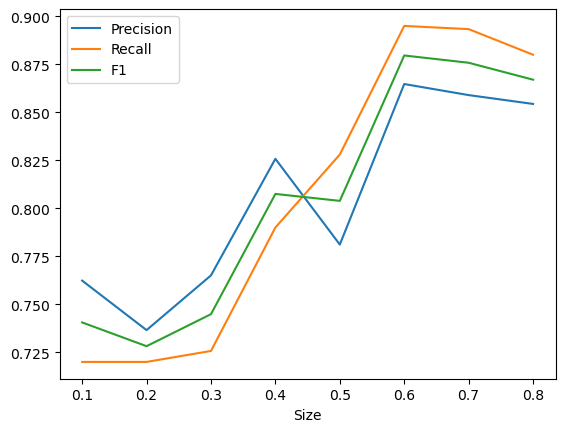

In [30]:
ax = df_metrics.plot(x="Size", y="Precision")
df_metrics.plot(x="Size", y="Recall", ax=ax)
df_metrics.plot(x="Size", y="F1", ax=ax)
_ = plt.legend()